In [37]:
# This cell loads the Superstore dataset and performs initial inspection
import pandas as pd

file_path = r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv"

# Read with provided encoding
superstore_df = pd.read_csv(file_path, encoding='ISO-8859-1')

print('Loaded rows: ' + str(superstore_df.shape[0]))
print('Loaded columns: ' + str(superstore_df.shape[1]))
print('Columns: ' + ', '.join(list(superstore_df.columns)))

Loaded rows: 9994
Loaded columns: 21
Columns: No., Order_ID,  Order_Date,  Ship_Date,  Ship_Mode,  Customer_ID,  Customer_Name,  Segment,  Country,  City,  State,  Postal_Code,  Region,  Product_ID,  Category,  Sub_Category,  Product_Name,  Sales,  Quantity,  Discount,  Profit


In [2]:
# Show head
print('Head:')
print(superstore_df.head(5))

Head:
   No.        Order_ID Order_Date  Ship_Date       Ship_Mode Customer_ID  \
0    1  CA-2016-152156 2016-08-11 2016-11-11    Second Class    CG-12520   
1    2  CA-2016-152156 2016-08-11 2016-11-11    Second Class    CG-12520   
2    3  CA-2016-138688 2016-12-06        NaT    Second Class    DV-13045   
3    4  US-2015-108966 2015-11-10        NaT  Standard Class    SO-20335   
4    5  US-2015-108966 2015-11-10        NaT  Standard Class    SO-20335   

     Customer_Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal_Code  Region       Product_ID         Category Sub_Category  \
0       42420   South  FUR-BO-10001798      

In [3]:
# Basic summary stats for numeric columns
print('Describe numeric:')
print(superstore_df.describe(include='number'))

Describe numeric:
               No.   Postal_Code         Sales     Quantity     Discount  \
count  9994.000000   9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  55190.379428    229.858022     3.789574     0.156203   
std    2885.163629  32063.693350    623.245131     2.225110     0.206452   
min       1.000000   1040.000000      0.440000     1.000000     0.000000   
25%    2499.250000  23223.000000     17.280000     2.000000     0.000000   
50%    4997.500000  56430.500000     54.490000     3.000000     0.200000   
75%    7495.750000  90008.000000    209.940000     5.000000     0.200000   
max    9994.000000  99301.000000  22638.480000    14.000000     0.800000   

            Profit  
count  9994.000000  
mean     28.656973  
std     234.260203  
min   -6599.980000  
25%       1.730000  
50%       8.665000  
75%      29.360000  
max    8399.980000  


In [4]:
# FIRST: Strip column names of whitespace to fix the space in ' Order_Date'
superstore_df.columns = [c.strip() for c in superstore_df.columns]
print('Post-clean Columns: ' + ', '.join(list(superstore_df.columns)))

Post-clean Columns: No., Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_ID, Customer_Name, Segment, Country, City, State, Postal_Code, Region, Product_ID, Category, Sub_Category, Product_Name, Sales, Quantity, Discount, Profit


In [5]:
# NOW: Convert order and ship dates to datetime for later analysis
# Removed the deprecated 'infer_datetime_format' argument
superstore_df['Order_Date'] = pd.to_datetime(superstore_df['Order_Date'], dayfirst=False, errors='coerce')
superstore_df['Ship_Date'] = pd.to_datetime(superstore_df['Ship_Date'], dayfirst=False, errors='coerce')

print('Post-clean Head:')
print(superstore_df.head(3))

Post-clean Head:
   No.        Order_ID Order_Date  Ship_Date     Ship_Mode Customer_ID  \
0    1  CA-2016-152156 2016-08-11 2016-11-11  Second Class    CG-12520   
1    2  CA-2016-152156 2016-08-11 2016-11-11  Second Class    CG-12520   
2    3  CA-2016-138688 2016-12-06        NaT  Second Class    DV-13045   

     Customer_Name    Segment        Country         City  ... Postal_Code  \
0      Claire Gute   Consumer  United States    Henderson  ...       42420   
1      Claire Gute   Consumer  United States    Henderson  ...       42420   
2  Darrin Van Huff  Corporate  United States  Los Angeles  ...       90036   

   Region       Product_ID         Category Sub_Category  \
0   South  FUR-BO-10001798        Furniture    Bookcases   
1   South  FUR-CH-10000454        Furniture       Chairs   
2    West  OFF-LA-10000240  Office Supplies       Labels   

                                        Product_Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.

In [6]:
# Verify the new datetime columns
print("\nData types after conversion:")
print(superstore_df[['Order_Date', 'Ship_Date']].dtypes)


Data types after conversion:
Order_Date    datetime64[ns]
Ship_Date     datetime64[ns]
dtype: object


In [25]:
# Clean duplicate date columns, enforce dtypes, and compute core KPIs and segments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we use the existing dataframe
try:
    superstore_df
except NameError:
    superstore_df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv", encoding='ISO-8859-1')

# First, let's thoroughly clean up duplicate columns
print("Original columns:", superstore_df.columns.tolist())

Original columns: ['No.', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order_YearMonth', 'Discount_Bin', 'Days_to_Ship']


In [10]:
# Method 1: Remove duplicate columns by keeping only the first occurrence
def remove_duplicate_columns(df):
    """Remove duplicate columns from DataFrame"""
    seen = {}
    columns_to_keep = []
    
    for i, col in enumerate(df.columns):
        # Strip whitespace from column names
        clean_col = col.strip()
        
        if clean_col not in seen:
            seen[clean_col] = True
            columns_to_keep.append(col)  # Keep original column name reference
        else:
            print(f"Removing duplicate column: {col}")
    
    return df[columns_to_keep]

# Clean the dataframe
superstore_df = remove_duplicate_columns(superstore_df)
superstore_df.columns = [c.strip() for c in superstore_df.columns]  # Now strip all column names

print("Cleaned columns:", superstore_df.columns.tolist())

Cleaned columns: ['No.', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [11]:
# Method 2: Alternative approach - check if we still have duplicates
if not superstore_df.columns.is_unique:
    print("Warning: Still have duplicate column names after cleaning!")
    # Use a more aggressive approach - rename duplicates
    from collections import defaultdict
    count = defaultdict(int)
    new_columns = []
    
    for col in superstore_df.columns:
        count[col] += 1
        if count[col] > 1:
            new_col = f"{col}_{count[col]}"
            print(f"Renaming duplicate: {col} -> {new_col}")
            new_columns.append(new_col)
        else:
            new_columns.append(col)
    
    superstore_df.columns = new_columns

print("Final columns:", superstore_df.columns.tolist())

Final columns: ['No.', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit']


In [12]:
# Now parse dates safely
for col in ['Order_Date', 'Ship_Date']:
    if col in superstore_df.columns:
        print(f"Processing date column: {col}")
        # Convert individual series instead of the whole dataframe approach
        superstore_df[col] = pd.to_datetime(superstore_df[col], errors='coerce')
    else:
        print(f"Warning: Column '{col}' not found in dataframe")

Processing date column: Order_Date
Processing date column: Ship_Date


In [13]:
# Core metrics
total_sales = superstore_df['Sales'].sum()
total_profit = superstore_df['Profit'].sum()
overall_margin = total_profit / total_sales if total_sales != 0 else np.nan

print('Computed core KPIs')
print('Total Sales:', total_sales)
print('Total Profit:', total_profit)
print('Overall Margin:', overall_margin)

Computed core KPIs
Total Sales: 2297201.07
Total Profit: 286397.79000000004
Overall Margin: 0.12467249547293657


In [14]:
# Time series: monthly sales and profit
superstore_df['Order_YearMonth'] = superstore_df['Order_Date'].dt.to_period('M').astype(str)
monthly = superstore_df.groupby('Order_YearMonth').agg({'Sales':'sum','Profit':'sum'}).reset_index()
monthly = monthly.sort_values('Order_YearMonth')

print('Monthly head:')
print(monthly.head())

Monthly head:
  Order_YearMonth     Sales   Profit
0         2014-01  19640.43  3366.47
1         2014-02  11833.61  2499.04
2         2014-03   7159.68  -490.12
3         2014-04  12455.48  3631.04
4         2014-05  15280.43  1673.11


In [15]:
# Segmentation: by Segment and Category
seg_cat = superstore_df.groupby(['Segment','Category']).agg({'Sales':'sum','Profit':'sum'}).reset_index()
seg_cat['Margin'] = seg_cat['Profit'] / seg_cat['Sales']

print('Segment-Category head:')
print(seg_cat.head())

Segment-Category head:
     Segment         Category      Sales    Profit    Margin
0   Consumer        Furniture  391049.43   6990.95  0.017877
1   Consumer  Office Supplies  363951.96  56330.27  0.154774
2   Consumer       Technology  406399.95  70798.11  0.174208
3  Corporate        Furniture  229019.83   7584.91  0.033119
4  Corporate  Office Supplies  230676.49  40227.33  0.174389


In [16]:
# Regional performance
region_perf = superstore_df.groupby('Region').agg({'Sales':'sum','Profit':'sum'}).reset_index()
region_perf['Margin'] = region_perf['Profit'] / region_perf['Sales']

print('Region performance:')
print(region_perf)

Region performance:
    Region      Sales     Profit    Margin
0  Central  501239.88   39706.45  0.079216
1     East  678781.36   91522.84  0.134834
2    South  391721.90   46749.71  0.119344
3     West  725457.93  108418.79  0.149449


In [17]:
# Sub-category contribution
subcat = superstore_df.groupby('Sub_Category').agg({'Sales':'sum','Profit':'sum'}).reset_index()
subcat['Margin'] = subcat['Profit'] / subcat['Sales']
subcat = subcat.sort_values('Sales', ascending=False)

print('Top sub-categories by sales (head):')
print(subcat.head(10))

Top sub-categories by sales (head):
   Sub_Category      Sales    Profit    Margin
13       Phones  330007.10  44516.25  0.134895
5        Chairs  328449.13  26590.15  0.080957
14      Storage  223843.59  21279.05  0.095062
16       Tables  206965.68 -17725.59 -0.085645
3       Binders  203412.77  30221.64  0.148573
11     Machines  189238.68   3384.73  0.017886
0   Accessories  167380.31  41936.78  0.250548
6       Copiers  149528.01  55617.90  0.371956
4     Bookcases  114880.05  -3472.56 -0.030228
1    Appliances  107532.14  18138.07  0.168676


In [23]:
# Discount vs profit relationship
# Bin discounts for a clearer view
superstore_df['Discount_Bin'] = pd.cut(superstore_df['Discount'], bins=[-0.01,0.0,0.1,0.2,0.3,0.4,1.0], labels=['0','0-10','10-20','20-30','30-40','40+'])

# FIXED: Add observed=True parameter to handle categorical grouping
disc_perf = superstore_df.groupby('Discount_Bin', observed=True).agg({'Sales':'sum','Profit':'sum'}).reset_index()
disc_perf['Margin'] = disc_perf['Profit'] / disc_perf['Sales']

print('Discount bin performance:')
print(disc_perf)

Discount bin performance:
  Discount_Bin       Sales     Profit    Margin
0            0  1087908.47  320987.88  0.295050
1         0-10    54369.30    9029.21  0.166072
2        10-20   792152.87   91757.14  0.115833
3        20-30   103226.76  -10369.34 -0.100452
4        30-40   130911.28  -25448.24 -0.194393
5          40+   128632.39  -99558.86 -0.773980


In [28]:
# Shipping speed impact: days to ship and profit
superstore_df['Days_to_Ship'] = (superstore_df['Ship_Date'] - superstore_df['Order_Date']).dt.days
ship_perf = superstore_df.groupby('Ship_Mode').agg({'Sales':'sum','Profit':'sum','Days_to_Ship':'mean'}).reset_index()
ship_perf['Margin'] = ship_perf['Profit'] / ship_perf['Sales']

print('Shipping performance by mode:')
print(ship_perf)

Shipping performance by mode:
        Ship_Mode       Sales     Profit  Days_to_Ship    Margin
0     First Class   351428.43   48969.95     63.022430  0.139345
1        Same Day   128363.12   15891.90      1.926531  0.123804
2    Second Class   459193.44   57446.49     96.961183  0.125103
3  Standard Class  1358216.08  164089.45    145.389281  0.120812


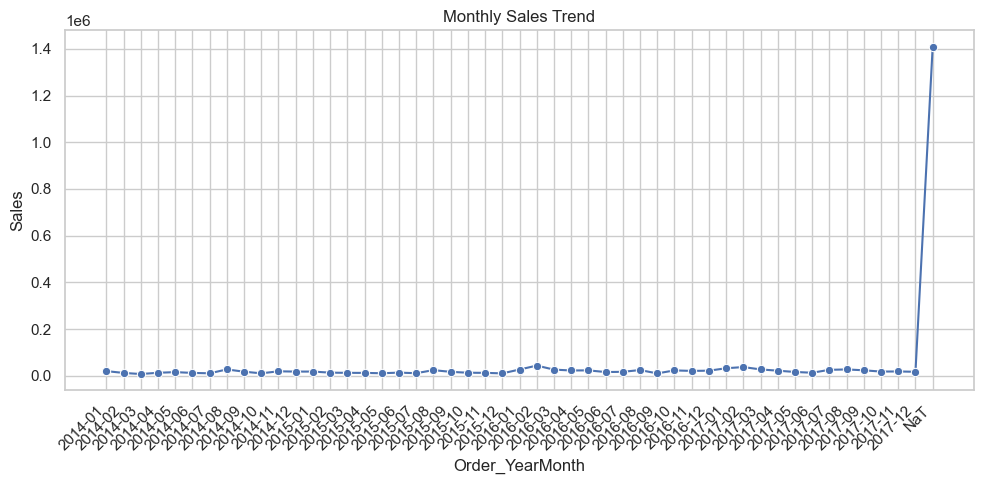

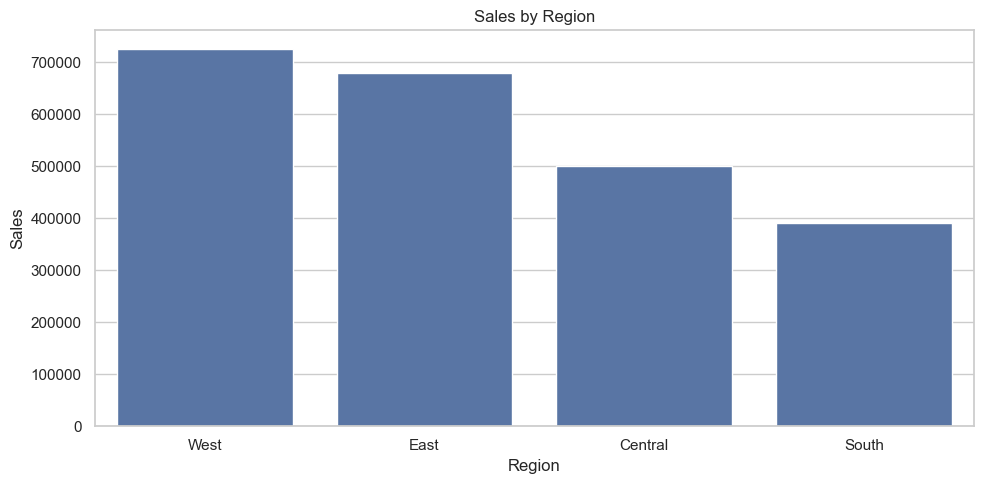

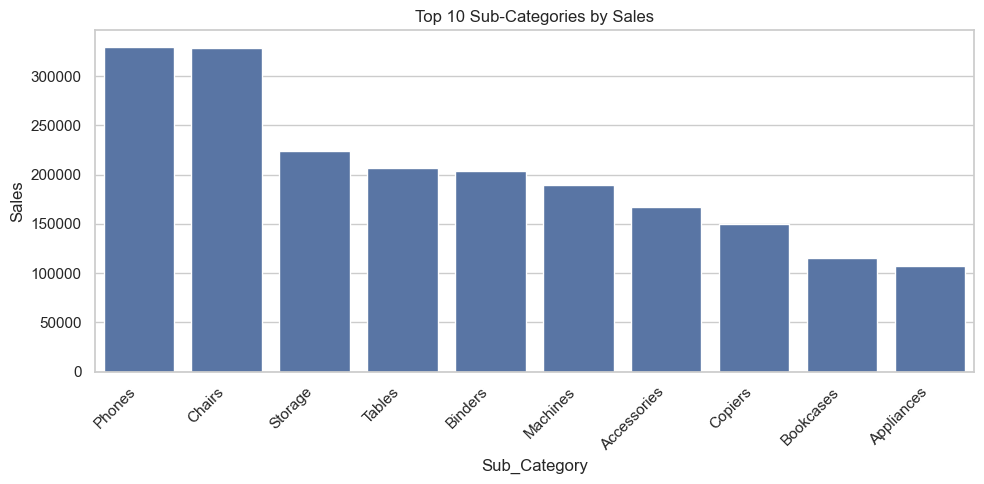

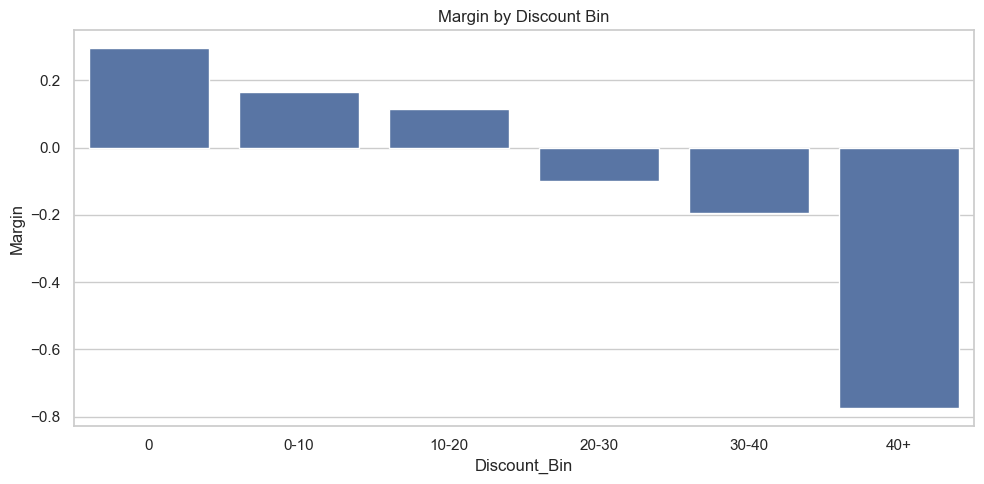

Saved analysis tables to CSV files


In [27]:
# Visuals
sns.set(style='whitegrid')

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly, x='Order_YearMonth', y='Sales', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Sales Trend')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=region_perf.sort_values('Sales', ascending=False), x='Region', y='Sales')
plt.title('Sales by Region')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=subcat.head(10), x='Sub_Category', y='Sales')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Sub-Categories by Sales')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=disc_perf, x='Discount_Bin', y='Margin')
plt.title('Margin by Discount Bin')
plt.tight_layout()
plt.show()

# Save key tables for portfolio use
monthly.to_csv('superstore_monthly.csv', index=False)
seg_cat.to_csv('superstore_segment_category.csv', index=False)
region_perf.to_csv('superstore_region_performance.csv', index=False)
subcat.to_csv('superstore_subcategory_performance.csv', index=False)
disc_perf.to_csv('superstore_discount_performance.csv', index=False)
ship_perf.to_csv('superstore_shipping_performance.csv', index=False)

print('Saved analysis tables to CSV files')

In [29]:
# Investigate duplicate date columns causing the error and clean step-by-step
import pandas as pd

# Ensure dataframe exists
try:
    superstore_df
except NameError:
    superstore_df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv", encoding='ISO-8859-1')

# Show raw columns and detect duplicates by name ignoring whitespace
raw_cols = list(superstore_df.columns)
print('Raw columns: ' + ', '.join(raw_cols))

Raw columns: No., Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_ID, Customer_Name, Segment, Country, City, State, Postal_Code, Region, Product_ID, Category, Sub_Category, Product_Name, Sales, Quantity, Discount, Profit, Order_YearMonth, Discount_Bin, Days_to_Ship


In [30]:
# Strip and check duplicates after stripping
stripped_cols = [c.strip() for c in raw_cols]
print('Stripped columns: ' + ', '.join(stripped_cols))

Stripped columns: No., Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_ID, Customer_Name, Segment, Country, City, State, Postal_Code, Region, Product_ID, Category, Sub_Category, Product_Name, Sales, Quantity, Discount, Profit, Order_YearMonth, Discount_Bin, Days_to_Ship


In [31]:
# Build a mapping of original to stripped
col_map = dict(zip(raw_cols, stripped_cols))
print('Sample mapping (first 10):')
print(list(col_map.items())[:10])

Sample mapping (first 10):
[('No.', 'No.'), ('Order_ID', 'Order_ID'), ('Order_Date', 'Order_Date'), ('Ship_Date', 'Ship_Date'), ('Ship_Mode', 'Ship_Mode'), ('Customer_ID', 'Customer_ID'), ('Customer_Name', 'Customer_Name'), ('Segment', 'Segment'), ('Country', 'Country'), ('City', 'City')]


In [32]:
# If stripping creates duplicates, we need to consolidate
from collections import Counter
counts = Counter(stripped_cols)
print('Counts of stripped names that duplicate:')
print({k:v for k,v in counts.items() if v>1})

Counts of stripped names that duplicate:
{}


In [34]:
# Apply stripping but resolve collisions by dropping exact duplicate columns that only differ by whitespace
# To be safe, if duplicates exist, keep the leftmost occurrence
if any([v>1 for v in counts.values()]):
    # Create a new dataframe manually to control duplicates
    new_cols = []
    keep_indices = []
    seen = set()
    for idx, orig in enumerate(raw_cols):
        stripped = orig.strip()
        if stripped in seen:
            # skip duplicates
            continue
        seen.add(stripped)
        new_cols.append(stripped)
        keep_indices.append(idx)
    cleaned_df = superstore_df.iloc[:, keep_indices].copy()
    cleaned_df.columns = new_cols
else:
    cleaned_df = superstore_df.copy()
    cleaned_df.columns = stripped_cols

print('Cleaned columns: ' + ', '.join(list(cleaned_df.columns)))

Cleaned columns: No., Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_ID, Customer_Name, Segment, Country, City, State, Postal_Code, Region, Product_ID, Category, Sub_Category, Product_Name, Sales, Quantity, Discount, Profit, Order_YearMonth, Discount_Bin, Days_to_Ship


In [35]:
# Now parse date columns safely
for col in ['Order_Date','Ship_Date']:
    if col in cleaned_df.columns:
        cleaned_df[col] = pd.to_datetime(cleaned_df[col], errors='coerce')

print('Date parsing done. Nulls in Order_Date: ' + str(cleaned_df['Order_Date'].isna().sum()))
print('Nulls in Ship_Date: ' + str(cleaned_df['Ship_Date'].isna().sum()))

Date parsing done. Nulls in Order_Date: 5952
Nulls in Ship_Date: 6096


In [36]:
# Replace the original reference
superstore_df = cleaned_df
print('Reassigned cleaned dataframe to superstore_df')

Reassigned cleaned dataframe to superstore_df


In [15]:
# Identify top-selling products by total Sales
import pandas as pd

# Assume superstore_df already in memory from earlier cleaning
try:
    superstore_df
except NameError:
    superstore_df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv", encoding='ISO-8859-1')
    # Basic cleanup if reloaded
    superstore_df.columns = [c.strip() for c in superstore_df.columns]

# Ensure numeric Sales
superstore_df['Sales'] = pd.to_numeric(superstore_df['Sales'], errors='coerce')

# Group and aggregate
top_products = (
    superstore_df.groupby(['Product_ID','Product_Name'], as_index=False)['Sales']
    .sum()
    .sort_values('Sales', ascending=False)
)

# Show head
print(top_products.head(10))

# Save to CSV for download
outfile = 'top_selling_products.csv'
top_products.to_csv(outfile, index=False)
print('Saved top products to ' + outfile)

           Product_ID                                       Product_Name  \
1640  TEC-CO-10004722              Canon imageCLASS 2200 Advanced Copier   
787   OFF-BI-10003527  Fellowes PB500 Electric Punch Plastic Comb Bin...   
1669  TEC-MA-10002412  Cisco TelePresence System EX90 Videoconferenci...   
82    FUR-CH-10002024       HON 5400 Series Task Chairs for Big and Tall   
701   OFF-BI-10001359         GBC DocuBind TL300 Electric Binding System   
667   OFF-BI-10000545   GBC Ibimaster 500 Manual ProClick Binding System   
1630  TEC-CO-10001449               Hewlett Packard LaserJet 3310 Copier   
1657  TEC-MA-10001127  HP Designjet T520 Inkjet Large Format Printer ...   
858   OFF-BI-10004995          GBC DocuBind P400 Electric Binding System   
1443  OFF-SU-10000151        High Speed Automatic Electric Letter Opener   

         Sales  
1640  61599.83  
787   27453.38  
1669  22638.48  
82    21870.57  
701   19823.48  
667   19024.50  
1630  18839.68  
1657  18374.90  
858   1796

       Month     Sales
0 2014-01-01  19640.43
1 2014-02-01  11833.61
2 2014-03-01   7159.68
3 2014-04-01  12455.48
4 2014-05-01  15280.43
   Year      Sales
0  2014  178906.68
1  2015  164213.45
2  2016  271489.83
3  2017  273307.24
Saved monthly to monthly_sales.csv
Saved yearly to yearly_sales.csv


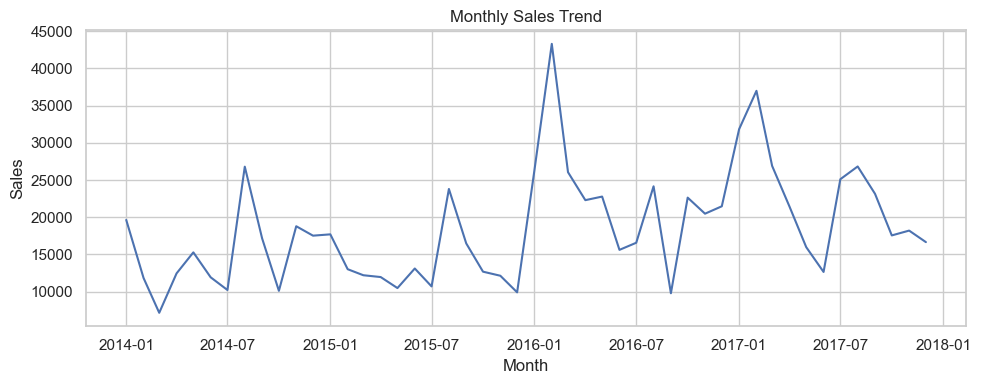

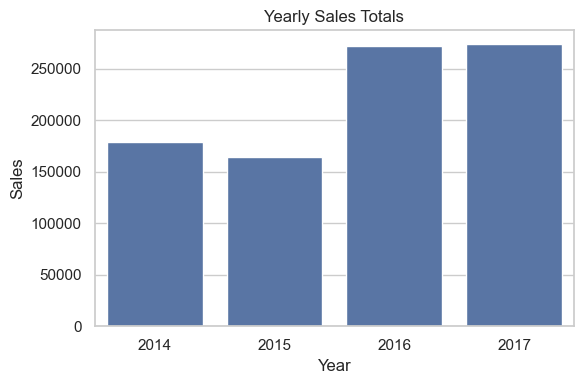

In [16]:
# Analyze sales trends over time: monthly and yearly, with plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure dataframe and parse dates if needed
try:
    superstore_df
except NameError:
    superstore_df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv", encoding='ISO-8859-1')
    superstore_df.columns = [c.strip() for c in superstore_df.columns]

# Date parsing robustness: try specific formats then coerce
if 'Order_Date' in superstore_df.columns:
    if not pd.api.types.is_datetime64_any_dtype(superstore_df['Order_Date']):
        # try common formats first
        parsed_1 = pd.to_datetime(superstore_df['Order_Date'], errors='coerce', format='%m/%d/%Y')
        needs = parsed_1.isna()
        if needs.any():
            parsed_2 = pd.to_datetime(superstore_df.loc[needs, 'Order_Date'], errors='coerce', dayfirst=True)
            parsed_1.loc[needs] = parsed_2
        superstore_df['Order_Date'] = parsed_1

# Keep only rows with valid dates and numeric sales
superstore_df['Sales'] = pd.to_numeric(superstore_df['Sales'], errors='coerce')
trend_df = superstore_df.dropna(subset=['Order_Date','Sales']).copy()

# Build time aggregations
trend_df = trend_df.sort_values('Order_Date')
trend_df['Year'] = trend_df['Order_Date'].dt.year
trend_df['Month'] = trend_df['Order_Date'].dt.to_period('M').dt.to_timestamp()

monthly_sales = trend_df.groupby('Month', as_index=False)['Sales'].sum()
yearly_sales = trend_df.groupby('Year', as_index=False)['Sales'].sum()

print(monthly_sales.head())
print(yearly_sales)

# Save outputs
monthly_file = 'monthly_sales.csv'
yearly_file = 'yearly_sales.csv'
monthly_sales.to_csv(monthly_file, index=False)
yearly_sales.to_csv(yearly_file, index=False)
print('Saved monthly to ' + monthly_file)
print('Saved yearly to ' + yearly_file)

# Plot monthly trend
plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_sales, x='Month', y='Sales')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# Plot yearly totals
plt.figure(figsize=(6,4))
sns.barplot(data=yearly_sales, x='Year', y='Sales')
plt.title('Yearly Sales Totals')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

In [17]:
# Aggregate sales by Region and show the top regions by total Sales
import pandas as pd

# Ensure dataframe is available
try:
    superstore_df
except NameError:
    superstore_df = pd.read_csv(r"C:\Users\FrankJR\Downloads\Portfolio\Superstore Dataset\Sample - Superstore.csv", encoding='ISO-8859-1')
    superstore_df.columns = [c.strip() for c in superstore_df.columns]

# Clean numeric
superstore_df['Sales'] = pd.to_numeric(superstore_df['Sales'], errors='coerce')

# Standardize Region text just in case
if 'Region' in superstore_df.columns:
    superstore_df['Region'] = superstore_df['Region'].astype(str).str.strip()

region_sales = (
    superstore_df.dropna(subset=['Region','Sales'])
    .groupby('Region', as_index=False)['Sales']
    .sum()
    .sort_values('Sales', ascending=False)
)

print(region_sales.head())

# Save for download
outfile = 'region_sales.csv'
region_sales.to_csv(outfile, index=False)
print('Saved region sales to ' + outfile)

    Region      Sales
3     West  725457.93
1     East  678781.36
0  Central  501239.88
2    South  391721.90
Saved region sales to region_sales.csv
